# Aprendizaje Automático 2020

## Entrega 1 - Teeko


### Grupo 20:
     - L. Dominguez  C.I 5.131.448-2
     - M. Miranda    C.I 4.774.499-8
     - L. Martins    C.I 4.404.992-9


## 1. Introducción

El objetivo de esta tarea es construir un programa que aprenda a jugar al *Teeko* entre dos oponentes utilizando un modelo lineal para evaluar las decisiones a ser tomadas durante la partida.

Se medirá el aprendizaje calculando el porcentaje de juegos ganados y viendo su evolución.

Adjuntos a este informe se entregan los siguientes archivos que contienen el código implementado:

- **constants.py**: Diccionario de constantes utilizadas en la solución.

- **game.py**: Se implementa la clase game, encargada de ejecutar la lógica del juego, hacer los movimientos, definir movimientos válidos, entre otras cosas. En él se encuentra la representación actual del tablero.

- **helpers.py**: Contiene funciones auxiliares para reducir el tamaño de los módulos game.py y player.py.

- **main.py**: En él se crean las instancias de las clases necesarias para jugar las partidas (juego, jugador, etc).

- **player.py**: Se define la clase asociada al jugador con dos tipos de jugadores, el aleatorio y el inteligente.

- **values_p1.txt**: Archivo de texto donde se persisten los pesos de la función de evaluación del jugador 1.

- **values_p2.txt**: Archivo de texto donde se persisten los pesos de la función de evaluación del jugador 2.

Para desplegar el menú de ayuda ejecute: **python3.7 main.py --help**

## 2. Diseño



### 2.1 Juego

Se mantienen todas las reglas del juego original salvo 2 pequeñas variantes: 
* En lugar de introducir las primeras piezas turno a turno, se comienza con un tablero (no ganador) generado aleatoriamente.
* Se agrega un límite de **200** movimientos por defecto para cada partida de forma evitar partidas infinitas. Al alcanzar dicho límite, la partida finaliza y el jugador que se encuentra aprendiendo es penalizado. Esta decisión se debe a que los ciclos de jugadas son causados por la función objetivo y es importante aprender que estas situaciones son indeseadas.

No se define ninguna otra situación de empate.



### 2.2 Tablero

Un tablero consiste en una tupla $\(estructura, atributos)\$, donde *estructura* es la representación de la estructura matricial del tablero y *atributos* es la representación funcional asociada al mismo.

### Representación de la estructura tablero
A nivel de estructura de datos, la representación del tablero consiste en una matriz $M_{5\times 5} (\mathbb{Z}) $, donde cada entrada $m_{ij}$ puede tomar los valores $\{ 0, 1 , 2 \}$, representando: 
- **0**: casilla libre.
- **1**: casilla ocupada por una pieza del Jugador 1.
- **2**: casilla ocupada por una pieza del Jugador 2.

Se eligió una representación matricial para aprovechar las funciones que brinda la librería *numpy* sobre estas estructuras.

Un ejemplo de tablero inicial es el siguiente:
<div>
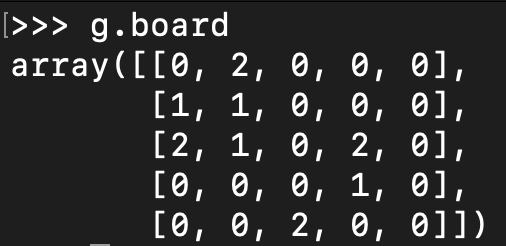
</div>
 
### Representación funcional del tablero
  
#### Los atributos elegidos para la tupla representación del tablero son los siguientes:

- #### $x_1$: Cantidad de *conexiones* entre fichas

Es la cantidad total de adyacencias que hay entre todas las fichas. Cada vez que una ficha tiene otra adyacente, el valor de adyacencias de la misma se aumenta en uno, lo que implica que se sume dos al valor *conexiones* (ya que cada una tiene a la otra de adyacente). Esta función toma valores entre **0** (representando que todas las fichas están aisladas) hasta **12** (todas están juntas formando un cuadrado).

Se elige este valor ya que, intuitivamente, las jugadas ganadoras tienen todas sus piezas conectadas y el máximo de esta función se da efectivamente en un tablero ganador así como su mínimo se da en una posición que se considera no es nunca favorable para ganar (todas las piezas aisladas)

- #### $x_2$: Máxima cantidad de fichas alineadas

Tal como lo dice su nombre, es la máxima cantidad de fichas alineadas de un determinado jugador en todo el tablero. Esta función puede tomar los valores desde **1** cuando todas las piezas están aisladas, hasta **4** cuando cuatro piezas están alineadas ya sea horizontal, vertical, diagonal izquierda o derecha (y por lo tanto el tablero es ganador). 

Se cree que también es un buen indicador de qué tan bien posicionado está un jugador para ganar la partida teniendo en cuenta que esta función toma su máximo al darse una configuración ganadora y el mínimo cuando se está lejos de la misma.

- #### $x_3$: Cantidad de *islas*

Esta función cuenta la cantidad de componentes conexas formadas por las fichas de un mismo jugador. Se considera que dos fichas están en la misma componente conexa si existe un camino de fichas adyacentes que las une. En otras palabras, se considera una componente conexa como la unión de una ficha juntos con sus adyacentes y las adyacentes de las mismas.

Esta función fue tomada en cuenta ya que todas las configuraciones de tableros ganadores coinciden en que están formadas por una única componente conexa y por lo tanto se da por supuesto que esta es una situación deseada, queriendo minimizar siempre el número de las mismas.

### Atributos restantes:

Por contraposición a los valores anteriores, se considera que entre mejor posicionado esté el oponente en un determinado tablero, peor será el valor del tablero del jugador ya que el contrincante se acerca a posiciones ganadoras, lo que podrían implicar la pérdida de la partida.
Por tales motivos se eligen los siguientes atributos:

- #### $x_4$: Cantidad de *conexiones* del oponente

En este caso, lo ideal sería evitar que el oponente pueda aumentar la cantidad de *conexiones*, por lo que idealmente este valor debería disminuir para evitar la pérdida de la partida luego de que el oponente forme un cuadrado (cuando este atributo llega a su máximo).

- #### $x_5$: Máxima cantidad de fichas alineadas del oponente

De la misma forma que $x_4$, bajo nuestras hipótesis, se querría minimizar este valor para que el oponente no gane a través de cuatro fichas alineadas.

- #### $x_6$: Cantidad de *islas* del oponente

Idealmente, evitando que el oponente forme una única componente conexa, se evita perder. Por lo tanto se considera que un tablero es bueno entre más componentes conexas tenga el oponente, representando que sus fichas están aisladas.


### Otros atributos no tomados en cuenta en nuestra solución:
Durante la discusión de la solución se analizaron otros posibles atributos que por diferentes motivos no fueron utilizados para la construcción del problema. A continuación se detallan algunos:

- #### Cantidad de movimientos mínimos para que el oponente disminuya sus islas (componentes conexas)

Se trató de incluir este atributo pero fue imposible por cuestiones de tiempos de implementación. Se cree que podría ser una buen medida contar la cantidad de movimientos mínimos para que el oponente disminuya su número de componentes. Lo bueno de haber podido implementar este atributo es que el valor es modificable directamente con las decisiones tomadas por el jugador. Por ejemplo: si el oponente pudiera formar una única componente con un solo movimiento y estuviera dentro de las posibilidades del jugador "tapar" una casilla, se aumentaría la cantidad de movimientos necesarios para (eventualmente) ganar.

- #### Cantidad de movimientos mínimos para alinear piezas

Las razones por las cuales no se implementó fueron las mismas que el anterior atributo. La implementación de estos últimos 2 atributos implicaría calcular todos los posibles caminos (secuencia de movimientos) para cada pieza y quedarnos con la más corta, algo muy similar a lo que resuelve un recorrido en BFS de un grafo.


### Algunos tableros ejemplo con sus valores:

##### Para los siguientes ejemplos se supone  que el jugador es el número 1 (oponente es número 2):
##### Ejemplo 1:
<div>
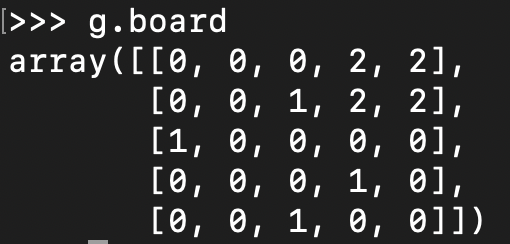
</div>

- Cantidad de *conexiones* entre fichas: 2
- Máxima cantidad de fichas alineadas: 2
- Cantidad de islas: 3
- Cantidad de *conexiones* del oponente: 12
- Máxima cantidad de fichas alineadas del oponente: 2
- Cantidad de *islas* del oponente: 1

_______________

##### Ejemplo 2:
<div>
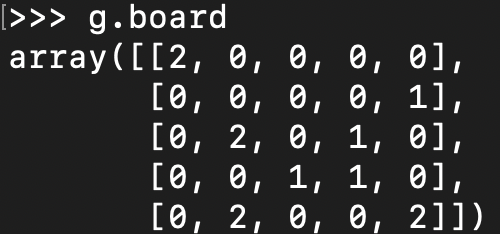
</div>

- Cantidad de *conexiones* entre fichas: 8
- Máxima cantidad de fichas alineadas: 3
- Cantidad de islas: 1
- Cantidad de *conexiones* del oponente: 0
- Máxima cantidad de fichas alineadas del oponente: 0
- Cantidad de *islas* del oponente: 4


### 2.3 Algoritmo

Tal como se pidió en el obligatorio, se implementaron dos jugadores con distintas estrategias, ambos dentro del modelo *Player*. El jugador *RandomPlayer* toma la decisión sobre su próxima jugada a realizar de forma aleatoria dentro de todas las posibles. Por otro lado, el jugador *LearningPlayer* evalúa todos los posibles siguientes tableros y elige el que maximiza el valor de la función $\hat{V}$, según los valores que  los atributos definidos en la sección **2.2** tienen hasta el momento. 

La experiencia de entrenamiento se evaluará de la secuencia de tableros correspondientes a una partida del juego. El último tablero corresponde a la jugada que finaliza el juego. A continuación se muestran los valores adoptados para cada caso (victoria, pérdida o empate por haber llegado a la máxima cantidad de movimientos):

1. Si $b$ es un estado final del tablero que se gana, entonces $V(b) = 1$
2. Si $b$ es un estado final del tablero que se pierde, entonces $V(b) = -1$
2. Si $b$ es un estado final del tablero que se empata, entonces $V(b) = -0,5$

Para el cálculo de la función, se hace una combinación lineal entre los atributos del tablero (representados por el vector *weight*, estando sus valores iniciales definidos en el módulo *constants*).
Luego de calcular esta combinación, el valor se normaliza utilizando la siguiente función monótona para que los valores funcionales queden contenidos en el intervalo [−1,1]:
\begin{equation*}
x_{norm} = f(x) = \frac{x}{1 + |x|}
\end{equation*}
 
Por lo tanto, cálculo de $\hat{V}$ será: 
 
>$\hat{V}(b) = w_0 + w_1.x_1 + w_2.x_2 + w_3.x_3 + w_4.x_4 + w_5.x_5 + w_6.x_6$


#### 2.3.1 Ajuste de pesos

Para estimar los ejemplos de entrenamiento usamos la misma idea que el libro del curso en el juego de damas.

>$V_{ent} (b) = \hat{V}(Sucesor(b))$ donde la función $Sucesor(b)$ devuelve el tablero sucesor al tablero $b$


Para realizar los ajustes de los pesos ($w_i$) nos basamos en el algoritmo introducido en el libro del curso LMS. Para cada ejemplo de entrenamiento $<b, V_{ent}(b)>$,  los pesos se ajustan con la siguiente fórmula:
                                                    
>$w_i = w_i + \mu(V_{ent}(b) − \hat{V}(b))x_i$

Los pesos iniciales, mostrados a continuación, se eligieron asumiendo que todos tienen importancias equivalentes. Por este motivo todos tienen el mismo módulo. Además algunos fueron ponderados negativamente ya que son atributos que se necesitan minimizar para obtener un valor más favorable de la función objetivo.

>$w_0= 0.2,  \quad w_1=-0.2, \quad w_2=0.2,  \quad w_3=0.2,  \quad w_4=0.2,  \quad w_5=-0.2,  \quad w_6=-0.2$

El ajuste de estos pesos se dará al finalizar cada partida teniendo en cuenta los $V_{ent}$ para los tableros finales.

## 3. Experimentación

### Experimentación 1 (contra jugador aleatorio):

Para la primera experimentación se entrenó el algoritmo contra un jugador aleatorio con 5000 partidas y con **500 movimientos máximos por partida** se obtuvo el siguiente vector de pesos:
$$(w_0,w_2,w_3,w_4,w_5,w_6, w_7)= (0.01180, 0.00196, 0.00098, 0.00196, 0.00196, 0.00295, 0.00098)$$

el cual se utilizó para jugar contra un jugador aleatorio (esta vez sin ajustar pesos) y se obtuvieron los siguientes resultados de la tabla 1:

<table>
  <tr>
    <th></th>
    <th>Ganadas</th>
    <th>Perdidas</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <td>2135</td>
    <td>1426</td>
    <td>1439</td>
  </tr>    
  <tr>
    <th>Porcentajes</th>
    <td>42,7%</td>
    <td>28,52%</td>
    <td>28,78%</td>
  </tr>
  <tr>
    <th>Sin empates</th>
    <td>59,95%</td>
    <td>40,05%</td>
    <td></td>
  </tr> 
  <caption>Tabla 1</caption>
</table>

Luego de analizar estos resultados, preocupa la cantidad de empates con respecto a la cantidad total de partidas así como el bajo porcentaje de ganadas (teniendo siempre en cuenta que el oponente elige su jugada de forma totalmente aleatoria). Con estos resultados se podría afirmar que nuestro jugador juega **casi** aleatoriamente.

### Experimentación 2 (contra jugador aleatorio):

Para solucionar el problema de la experimentación anterior, se decide introducir un movimiento aleatorio cada 5 jugadas por parte del jugador inteligente y de esta manera se obtienen los siguientes resultados expresados en la tabla 2:

<table>
  <tr>
    <th></th>
    <th>Ganadas</th>
    <th>Perdidas</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <td>4803</td>
    <td>180</td>
    <td>17</td>
  </tr>    
  <tr>
    <th>Porcentajes</th>
    <td>96,06%</td>
    <td>3,6%</td>
    <td>0,34%</td>
  </tr>
  <tr>
    <th>Sin empates</th>
    <td>96,39%</td>
    <td>3,61%</td>
    <td></td>
  </tr> 
  <caption>Tabla 2</caption>
</table>

Con estos nuevos resultados no solo podemos afirmar que se redujo a un porcentaje despreciable el porcentaje de empates, sino que nuestro jugador inteligente comenzó a ganar (en términos relativos a la anterior prueba) todos los empates y aún más partidas. Esto es: si diéramos todos las partidas empatadas de la prueba anterior como ganadas al jugador inteligente sumaría 71,48%, sin embargo supera ampliamente este porcentaje.
Luego de esta mejora se baja límite de movimientos de 500 a 200 ya que deja de ser necesario y de esta forma se logra reducir los tiempos de ejecución largos provocados por los loops infinitos de partidas empates.


### Experimentación 3 (contra jugador inteligente y con pesos fijos):

Se experimentó jugar 5000 partidas con dos jugadores inteligentes con exactamente el mismo vector de atributos esperando que la mayoría de los resultados terminaran en empate o que la cantidad de perdidos y empatados resultaran muy similares y se obtuvieron los siguientes resultados:

<table>
  <tr>
    <th></th>
    <th>Ganadas</th>
    <th>Perdidas</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <td>2545</td>
    <td>2455</td>
    <td>0</td>
  </tr>    
  <tr>
    <th>Porcentajes</th>
    <td>50,9%</td>
    <td>49,1%</td>
    <td>0%</td>
  </tr>
  <caption>Tabla 3</caption>
</table>

De la *tabla 3* se puede deducir que los resultados fueron los esperados aunque se esperaba algún empate que no sucedió.

### Experimentación 4 (contra jugador aleatorio y aprendiendo):

En una de tantas experimentaciones se encuentra con algo que fue contra la intuición del equipo y se creyó conveniente registrar:
Utilizando los siguientes valores aprendidos de jugar contra un jugador aleatorio, se decidió jugar contra un jugador inteligente teniendo inicialmente ambos los mismos pesos:
$$(w_0,w_2,w_3,w_4,w_5,w_6, w_7)=(0.01178003, 0.00196333, 0.00098166, 0.005890015, 0.002945007, 0.00098166, 0.000981669)$$
Luego de mil partidas se obtuvieron los siguientes resultados:

<table>
  <tr>
    <th></th>
    <th>Ganadas</th>
    <th>Perdidas</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <td>179</td>
    <td>821</td>
    <td>0</td>
  </tr>    
  <tr>
    <th>Porcentajes</th>
    <td>18%</td>
    <td>82%</td>
    <td>0%</td>
  </tr>
  <caption>Tabla 4</caption>
</table>

Se cree que los malos resultados se deben a que los valores obtenidos anteriormente eran óptimos y se cayó en un sobre-ajuste con los nuevos casos.

### Experimentación 5 con distintos valores de $\mu$:

Se experimentó aprender contra un jugador aleatorio jugando 500 partidas y usando distintos valores de $\mu$ para comparar los resultados obtenidos y se obtuvieron los siguientes resultados:

<table>
  <tr>
    <th></th>
    <th>$\mu$</th>
    <th>Ganadas</th>
    <th>Perdidas</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <th>1</th>
    <td>478</td>
    <td>22</td>
    <td>0</td>
  </tr>    
  <tr style='font-weight:bold;'>
    <th>Totales</th>
    <th>0.01</th>
    <td>486</td>
    <td>14</td>
    <td>0</td>
  </tr>
  <tr>
    <th>Totales</th>
    <th>0.0001</th>
    <td>453</td>
    <td>26</td>
    <td>21</td>
  </tr>
  <tr>
    <th>Totales</th>
    <th>0,000001</th>
    <td>442</td>
    <td>30</td>
    <td>28</td>
  </tr>
  <caption>Tabla 5</caption>
</table>

A partir de estos resultados se concluye que al disminuir $\mu$ tanto el porcentaje de partidas perdidas como empatadas aumenta, siendo desfavorable para el jugador aprendiendo, por lo que se elige el valor que da mayor rate de partidas ganadas ($\mu=0,01$).

### Experimentación 6:
Para esta experimentación se entrenó por un lado a un jugador $j_1$ con su versión anterior y por otro a un jugador $j_2$ un oponente aleatorio. Luego se procedió a enfrentar 100 veces a $j_1$ y $j_2$ para observar su desempeño.

<table>
  <tr>
    <th></th>
    <th>Ganadas Jugador 1</th>
    <th>Ganadas Jugador 2</th>
    <th>Empatadas</th>

  </tr>
  <tr>
    <th>Totales</th>
    <td>32</td>
    <td>68</td>
    <td>0</td>
  </tr>    
  <tr>
    <th>Porcentajes</th>
    <td>32%</td>
    <td>68%</td>
    <td>0%</td>
  </tr>
  <caption>Tabla 6</caption>
</table>

Se puede observar que el jugador entrenado con el oponente aleatorio tiene un mejor desempeño. Una posible explicación es el conjunto de datos de entrenamiento generados para cada entrenamiento. En el caso del oponente aleatorio, los ejemplos de entrenamiento generados tienen mayor diversidad, por lo que el jugador que aprende se enfrentará con más ejemplos de tableros bien diferentes. En el caso del jugador que entrena con su versión anterior, el conjunto de ejemplos de entrenamiento es menos diverso, ya que el oponente está condicionado a la función de evaluación con sus respectivos pesos.
Este experimento nos permite ver el impacto que tiene un conjunto de entrenamiento representativo en la performance del jugador.

## 4. Conclusión

Diseñar un algoritmo de aprendizaje automático implica tareas de diseño, como se vio, elegir el tipo de experiencia de entrenamiento, la función objetivo a ser aprendida, la representación de esta función, como también el algoritmo para aprender la función objetivo. En este caso, el aprendizaje se hizo de forma autodidacta y por refuerzos al finalizar cada partida.

Los mejores resultados del jugador se obtuvieron cuando se introdujo una jugada aleatoria, cada 5 movimientos al jugador que aprende, “esto se debe a que gracias a la aleatoriedad (como tirar dados), se puede lograr una suficiente variedad de posiciones de entrenamiento” $^{[1]}$. 

Además, al aprender con un jugador aleatorio, se obtuvieron los mejores resultados con una constante de aprendizaje de 0.01, con el cual se logró minimizar el número de derrotas y empates (14 y 0  respectivamente, en 500 partidas). No obstante, cuanto más bajo es el valor de este hiper-parámetro, más lenta puede ser la convergencia al mínimo local, especialmente en casos de regiones de meseta.$^{[2]}$

Se observó, al realizar la partida entre dos oponentes inteligentes, donde uno representaba una versión anterior, que el oponente que seguía aprendiendo presentó una muy leve ventaja, lo que refleja que la mayor parte del conocimiento, fue obtenido en etapas iniciales.   

Para mejorar los resultados, algunas de las propuestas que surgieron, tienen que ver con la exploración de nuevos atributos, o la normalización de los atributos existentes, donde se busca que los parámetros ingresados a la función objetivo, tengan todos el mismo rango, para que tengan igual contribución. $^{[1]}$

Algo semejante ocurrió con la tasa de aprendizaje, a la cual se le pudo aplicar fórmulas cíclicas para salir de mínimos locales, o también, fórmulas de envejecimiento, donde, a medida que se avanza en las iteraciones, esta sea menor, y de esta forma minimizar los errores.

Con respecto al diseño del algoritmo, se notó que una importante parte de las victorias eran obtenidas formando un cuadrado, por lo que se puede afirmar que el algoritmo le da una leve prioridad a esta forma de ganar sobre las demás.

## 5. Referencias

1. https://www.fing.edu.uy/inco/grupos/pln/prygrado/InformeGO.pdf
2. https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10